In [78]:
from lib.data_prep import prepare_data_feat_step
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

stock_price=pd.read_csv('../data/TSLA.csv')
stock_price.index=pd.DatetimeIndex(stock_price['Unnamed: 0'])

In [79]:
training_days=int(len(stock_price)*0.75)
n_lags=5
step=0
target_col='Close'
extra_features=['Volume']
X_train, y_train, X_test, real_stock_price, sc_extra=prepare_data_feat_step(stock_price, training_days, n_lags, step, target_col, extra_features)


In [80]:
from lib.models import rnn_model, lstm_horizon_model
y_train = y_train.reshape(-1, 1)
model = lstm_horizon_model(X_train, y_train)


In [81]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
# Define TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with TensorBoard callback
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[tensorboard_callback])

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 69112.2109 - val_loss: 59758.2852
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 72373.2578 - val_loss: 57946.2773
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 68050.3906 - val_loss: 54717.6641
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 63257.2383 - val_loss: 53933.5195
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 62879.6562 - val_loss: 53471.3906
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 62606.2578 - val_loss: 53070.1719
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 64613.7773 - val_loss: 52695.1641
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 63874.5000 - val_loss: 52338.7891
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 62033.9688 - val_loss: 51994.1445
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 61648.6328 - val_loss: 51657.1719
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 61759.933

#### Test predicting single value

In [82]:
# To predict a single value
def predict_single_value(model, X_input):
    X_input = np.expand_dims(X_input, axis=0)  # Adjust shape to (1, 5, 2)
    prediction = model.predict(X_input)
    return prediction

# Example usage:
X_sample = X_train[0]  # Example input, a single sample from X_train
predicted_value = predict_single_value(model, X_sample)
sc=sc_extra[target_col]
print(sc.inverse_transform(predicted_value))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
[[13573.19]]


In [83]:
predicted_value

array([[44.605595]], dtype=float32)

### Predict test using LSTM model

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


<Axes: >

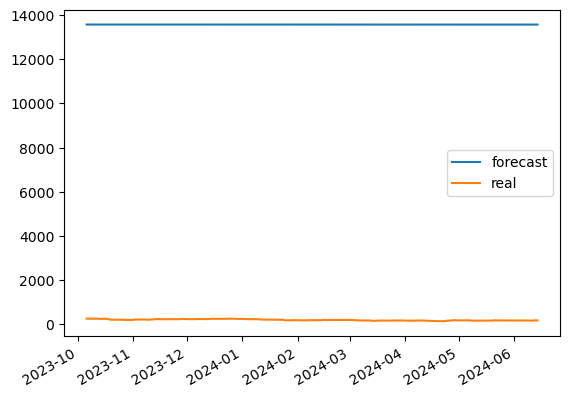

In [84]:
#predict test with trained model
#
y_pred=model.predict(X_test)
#get the right scaller
sc=sc_extra[target_col]
y_pred=sc.inverse_transform(y_pred)

y_pred_df=pd.DataFrame({'forecast':y_pred.reshape(-1),
                        'real':real_stock_price[target_col].values},
                        index=real_stock_price.index.values)

y_pred_df.plot()


In [ ]:
# Create autoregressive model for the all predicted horizon of test data

In [ ]:
#Create the 

### Use XGBoost model

In [61]:
#Get and train on scaled data
X_train_df=pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
col_vals=[target_col]+extra_features
cols_res=[]
for c in col_vals:
    for i in range(1, n_lags+1,1):
        cols_res.append(f'{c}_{n_lags-i+1}')
X_train_df.columns=cols_res
train_ind=stock_price.iloc[n_lags:training_days].index

X_train_df.index=train_ind
y_train_df=pd.Series(y_train.squeeze(-1),index=train_ind)

X_test_df=pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_test_df.columns=cols_res

In [62]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train_df,y_train_df )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [68]:
xgb_pred=model.predict(X_test_df)
sc=sc_extra[target_col]
xgb_pred=sc.inverse_transform(xgb_pred.reshape(len(xgb_pred),1))


<Axes: >

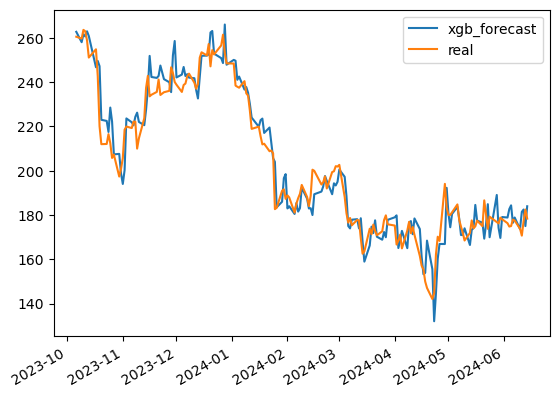

In [69]:
xgb_pred_df=pd.DataFrame({'xgb_forecast':xgb_pred.reshape(-1),
                        'real':real_stock_price[target_col].values},
                        index=real_stock_price.index.values)

xgb_pred_df.plot()